In [1]:
import time
import glob
import random

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
from tensorflow.keras.utils import Sequence
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import Dropout, Flatten 
from keras.layers import Conv1D, MaxPooling1D

2022-08-01 20:18:57.865270: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib:/usr/local/lib:/usr/local/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu:/srv/conda/envs/notebook/lib:/usr/local/harris/idl88/bin/bin.linux.x86_64
2022-08-01 20:18:57.865314: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Configuration variables and path setup

In [2]:
csvPath = '/efs/tnarock/fluxrope_data/cc_noise/'

allFiles = glob.glob( csvPath + "*.csv" )
random.shuffle(allFiles)
print("Dataset size:", len(allFiles))

Dataset size: 573300


In [9]:
subsetFiles = []
for file in allFiles:
    parts = file.split('/')
    fname = parts[-1]
    parts = fname.split('_')
    y0 = int(parts[6])
    if ( (y0 > -75) and (y0 < 75) ):
        subsetFiles.append(file)
print("Subset size:", len(subsetFiles))

Subset size: 426300


In [11]:
# Distribution is 60% Training, 20% Validation, and 20% Testing
cutOff = int(len(subsetFiles) * 0.6)
train = subsetFiles[:cutOff]
rest = subsetFiles[cutOff:]

# there's 40% left over, split it in half for testing and validation
test = rest[ : int(len(rest) * 0.5)]
validation = rest[ int(len(rest) * 0.5) : ]

print("Training files:", len(train))
print("Test files:", len(test))
print("Validation files:", len(validation))
print()
print("Total number of files:", len(subsetFiles))

# check to make sure we split everything correctly
total = len(test) + len(train) + len(validation)
assert total == len(subsetFiles)

Training files: 255780
Test files: 85260
Validation files: 85260

Total number of files: 426300


In [12]:
def readCSV(files):
    
    count = len(files)
    dataX = np.zeros(shape=(count, 50, 3))
    
    p = np.zeros( shape=(count,2) )
    t = np.zeros( shape=(count,2) )
    y0 = np.zeros( count )
    h = np.zeros( count )
    
    index = 0
    for f in files:
        
        # extract the output value from the file name
        parts = f.split("/")
        fname = parts[-1]
        parts = fname.split("_")   
        
        del parts[2] #Adjustment made only for noise data, convention purposes
        
        phi = float(parts[3])
        theta = float(parts[4])
        y0R = float(parts[5])
        HH = parts[6]
        parts = HH.split(".")
        HH = float(parts[0])
        
        y0[index] = y0R
        
        p[index, 0] = np.sin( np.radians(phi) )
        p[index, 1] = np.cos( np.radians(phi) )
        
        t[index, 0] = np.sin( np.radians(theta) )
        t[index, 1] = np.cos( np.radians(theta) )
                
        # change handedness from -1 or 1 to 0 or 1 to align with 
        # neural network sigmoid function
        if (HH == -1):
            h[index] = 0
        else:
            h[index] = 1
                    
        # read the data
        bx = []
        by = []
        bz = []
        openFile = open(f, "r")
        for line in openFile:
            parts = line.split(",")
            bx.append(float(parts[0]))
            by.append(float(parts[1]))
            bz.append(float(parts[2]))
        openFile.close()
        
        bx = np.array(bx)
        by = np.array(by)
        bz = np.array(bz)
        b = np.sqrt( bx*bx + by*by + bz*bz )
        phi = np.degrees(np.arctan2(bx,by))
        theta = np.degrees(np.arcsin( bz/b ))

        dataX[index, :, 0] = bx
        dataX[index, :, 1] = by
        dataX[index, :, 2] = bz
        
        index += 1

    return dataX, p, t, y0, h

In [13]:
import os

def makeNpzFiles(fileList, batchSize, outDir):
    
    # make sure there are no npz files left over from a previous run
    c = 0
    for filename in os.listdir(outDir):
        file_path = os.path.join(outDir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
                c += 1
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

    print("Deleted", c, "npz files in", outDir)
        
    loops = int(np.ceil(len(fileList)/batchSize))
    index1 = 0
    index2 = batchSize
    numFiles = 0
    for l in range(loops):
        files = fileList[index1:index2]

        x, p, t, y0, h = readCSV(files)
        if (l < 10):
            counter = '00' + str(l)
        elif ( (l >= 10) and (l < 100) ):
            counter = '0' + str(l)
        else:
            counter = str(l)
        outfile = outDir + 'fluxropes_' + counter + '.npz'
        np.savez(outfile, x=x, phi=p, theta=t, y0=y0, h=h, files=files)
        index1 = index2
        index2 += batchSize
        numFiles += 1
    print("Created", numFiles, "npz files in", outDir)

In [14]:
makeNpzFiles(train, 256, '/efs/tnarock/y0_data/npz_training/')
makeNpzFiles(validation, 256, '/efs/tnarock/y0_data/npz_validation/')
makeNpzFiles(test, 256, '/efs/tnarock/y0_data/npz_testing/')

Deleted 0 npz files in /efs/tnarock/y0_data/npz_training/
Created 1000 npz files in /efs/tnarock/y0_data/npz_training/
Deleted 0 npz files in /efs/tnarock/y0_data/npz_validation/
Created 334 npz files in /efs/tnarock/y0_data/npz_validation/
Deleted 0 npz files in /efs/tnarock/y0_data/npz_testing/
Created 334 npz files in /efs/tnarock/y0_data/npz_testing/


In [2]:
train = glob.glob( "/efs/tnarock/y0_data/npz_training/*.npz" )
validation = glob.glob( "/efs/tnarock/y0_data/npz_validation/*.npz" )
testing = glob.glob( "/efs/tnarock/y0_data/npz_testing/*.npz" )

random.shuffle(train)
random.shuffle(validation)
random.shuffle(testing)

### Data reader

In [3]:
class DataGenerator(Sequence):
    
    def __init__(self, files, batch_size=1, shuffle=False):
        
        self.batch_size = batch_size
        self.files = files
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        
        'Denotes the number of batches per epoch'

        'If the batch size doesnt divide evenly then add 1'
        diff = (len(self.files) / self.batch_size) - np.floor((len(self.files) / self.batch_size))
        if ( diff > 0 ):
            return int(np.floor(len(self.files) / self.batch_size))+1
        else:
            return int(np.floor(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # get list of files
        files = [self.files[k] for k in indexes]

        npzfile = np.load(files[0])
        x = npzfile['x']
        p = npzfile['phi']
        t = npzfile['theta']
        y0 = npzfile['y0']/100.
        h = npzfile['h']
        
                  
        #y = {"phi": p, "theta": t, "y0": y0, "handedness": h}
        
        size = p.shape[0]
        
        y = np.zeros(shape=(size,6))
        y[:,0] = p[:,0]
        y[:,1] = p[:,1]
        y[:,2] = t[:,0]
        y[:,3] = t[:,1]
        y[:,4] = y0[:]
        y[:,5] = h[:]
        
        return x, y

    def on_epoch_end(self):
        
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

### Train the model

### Custom Loss Function

In [4]:
import numpy as np
from numpy import sin as sin
from numpy import cos as cos
import warnings, traceback, sys

def ec_create_data(delta,
    phi,
    theta,
    psi,
    y0,
    h,
    C10=1,
    By0=10,
    us = 450.0,
    R=0.07,
    tau=1.3,
    n = 1,
    m = 0,
    norm_poloidal=True,
    noise_type='none',
    epsilon=0.05,
    num=50):
    """
    The Elliptic-cylindrical Magnetic Flux Rope Model

    A python implementation of the model by T. Nieves-Chinchilla et al. from
    https://doi.org/10.3847/1538-4357/aac951

    Parameters
    ----------
    All angles are expected in units of degrees.

    Coordinate system described are with the assumption that the 
    spacecraft trajectory is along the GSEx direction.
    (TODO: generalize these descriptions to reflect a relationship
    with the S/C RTN system)

    delta : float, A measure of the ellipticity of the flux rope.  
            The ratio between the length of the minor and major axes
            of the elliptical cross section. Valid range (0,1]
    
    phi : float, Angle of rotations of the flux rope around the Z axis, in 
          the XY plane. Valid range [0,360]
    
    theta : float, Angle of rotation of the flux rope out of the XY plane. 
            Valid range [-90, 90]
    
    psi : float, Angle of rotation about the central axis of the flux rope.
          Valid range [0,180]
    
    y0 : float, Spacecraft distance from the central axis of the flux rope.
         Valid range (-100, 100)
    
    h :  int, {-1, 1} Helicty of flux rope.

    C10 : int, optional, default: 1
         Valid only if > 0

    By0 : int, optional, default: 10

    tau : float, optional, default: 1.3

    us : float, optional, default: 450.0
         Spacecraft velocity in km/s

    R : float, optional, default: 0.07
        Radius of the semi-major axis in Astronomical Units (AU)

    n : float, optional, default: 1.0

    m : float, optional, default: 0.0

    norm_poloidal : boolean, optional, default: True
        If True, divide poloidal components by Bmax

    noise_type : {'none,'gaussian','uniform'}, optional, default: 'none'
        The type of noise to add to each component of the magnetic field 
        result.

    epsilon : float > 0, optional, default: 0.05
        Size of noise modifier.  Ignored if noise_type is 'none'.
        
        For noise_type 'gaussian', epsilon is the standard deviation of the 
        normal distrubution centered on 0.  Values in the distribution
        Normal(mu=0,sigma=epsilon) are added to the magnetic field components.

        For noise_type 'uniform', epsilon defines the +/- bounds of the 
        distribution.  Values in [-epsilon,epsilon] are added to the magnetic
        field components.

    num : int, optional, default: 50
        Length of return data time series in points.
    """

    # Store values for warning messages
    phi_in = phi
    th_in  = theta
    psi_in = psi
    y0_in  = y0

    #assert delta <= 1 and delta > 0, "DELTA must be in (0,1]"
    #assert phi > 0 and phi < 360, "PHI must be in (0,360)"
    #assert phi != 180, "PHI cannot be 180"
    #assert theta >= -90 and theta <= 90, "THETA must be in [-90,90]"
    #assert psi >= 0 and psi <= 180, "PSI must be in [0,180]"
    #assert y0 > -100 and y0 < 100, "Y0 must be in (-100,100)"
    y0[y0 < -100] = -100
    y0[y0 >  100] =  100
    
    #assert h == 1 or h == -1, "H must be in {-1, 1}"
    #assert C10 > 0, "C10 must be > 0"
    # TODO: error checks for By0, tau and R ranges

    # Constants
    AU_to_km = 1.5e8
    AU_to_m  = 1.5e11

    # Derived parameters
    if norm_poloidal:
        Bmax = delta * By0 * tau
    else:
        Bmax = 1.

    # Adjust arguments for internal coordinate system and convert to radians
    phi = np.radians(phi-90.)
    #phi = tf.angle(phi-90.)
    
    #if (phi < 0):
        #phi += 2 * np.pi
    phi[phi < 0] = phi + 2*np.pi    
        
    theta = np.radians(theta)
    psi = np.radians(psi)
    y0 = y0*R/100.


    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            #TODO: Give BGSE a more generic name.  
            # My understanding is it's essentially a rotation of the RTN system.

            HH_factor = np.sqrt(1 - (sin(phi) * cos(theta))**2)
            z0 = y0 * HH_factor / (cos(theta) * cos(phi))

            fctr1 = cos(psi)**2 + (delta * sin(psi))**2 # b-term in the notes
            fctr2 = sin(psi)**2 + (delta * cos(psi))**2 # a-term in the notes
            fctr3 = delta**2 - 1

            F2 = fctr1 * cos(phi)**2 \
                + fctr2 * (sin(phi) * sin(theta))**2 \
                + 2 * fctr3 * cos(phi)  * sin(phi) * sin(theta) * cos(psi) * sin(psi)

            F1 = fctr2 * sin(phi) * sin(theta) * cos(theta) \
                + fctr3 * cos(phi) * cos(theta) * sin(psi) * cos(psi)

            time_final = AU_to_km * (2./us) * (1./F2) \
                        * np.sqrt(F2 * R**2 - (HH_factor*y0)**2)
            
            tt = np.linspace(0,time_final,num=num)

            xc = (500 * time_final * us / AU_to_m) - (z0 * F1 / F2)
            AA = -xc * (cos(phi) * cos(psi) - sin(phi) * sin(theta) * sin(psi)) \
                + cos(theta) * sin(psi) * z0

            BB = -xc * (cos(phi) * sin(psi) + sin(phi) * sin(theta) * cos(psi)) \
                - cos(theta) * cos(psi) * z0

            RR = np.sqrt((AA/delta)**2 + BB**2)

            xsat = (1.0e3 * us * tt / AU_to_m) - xc

            XL = xsat * (cos(phi) * cos(psi) - sin(phi) * sin(theta) * sin(psi)) \
                + cos(theta)*sin(psi)*z0
            YL = -sin(phi) * cos(theta) * xsat + sin(theta) * z0
            ZL =  xsat * (cos(phi) * sin(psi) + sin(phi) * sin(theta) * cos(psi)) \
                - cos(theta) * cos(psi) * z0
            rnm = np.sqrt(XL**2 + ZL**2)
            PHIsat = np.arctan2(ZL,XL)
            HH_f = np.sqrt((delta * sin(phi))**2 + cos(phi)**2)
            HR = np.sqrt(sin(phi)**2 + (delta * cos(phi))**2)

            By = delta * By0 * (tau - (rnm/RR)**(n+1)) / Bmax
            fctr = (n+1) / (delta**2 + m + 1)
            Bpol = -h * delta * HH_f * fctr * (By0 / C10) * (rnm/RR)**(m+1) / Bmax

            if noise_type == 'fractal':
                if (num%2)==0:
                    frac_by,_ = fractal_synth(hpar=0.354844, std=1.321449, nfreq=num/2, verbose=False)
                    frac_bpol,_ = fractal_synth(hpar=0.319066, std=1.270344, nfreq=num/2, verbose=False)
                else:
                    raise ValueError('If noise_type == "fractal" you need to select num such as num/2 is in integer!')
                
                By = By + frac_by
                Bpol = Bpol + frac_bpol
                
            BxL = -Bpol * sin(PHIsat)
            ByL = By
            BzL = Bpol * cos(PHIsat)

            BxGSE = (BxL * (cos(phi) * cos(psi) - sin(psi) * sin(phi) *sin(theta)) 
                - ByL * sin(phi) * cos(theta) 
                + BzL * (cos(phi) * sin(psi) + cos(psi) * sin(phi) * sin(theta)))

            ByGSE = BxL* (sin(phi) * cos(psi) + sin(psi) * cos(phi) *sin(theta)) \
                + ByL * cos(phi)*cos(theta) \
                + BzL * (sin(phi) * sin(psi) - cos(psi) * cos(phi) * sin(theta))

            BzGSE = -BxL * sin(psi) * cos(theta) \
                + ByL * sin(theta) \
                + BzL * cos(psi) * cos(theta)


            # Add the noise
            if noise_type == 'uniform':
                rng = np.random.default_rng()   #Random number Generator
                BxGSE = 2 * epsilon * rng.random(num) - epsilon
                ByGSE = 2 * epsilon * rng.random(num) - epsilon
                BzGSE = 2 * epsilon * rng.random(num) - epsilon

            elif noise_type == 'gaussian':
                rng = np.random.default_rng()   #Random number Generator
                BxGSE += rng.normal(0,epsilon,num)
                ByGSE += rng.normal(0,epsilon,num)
                BzGSE += rng.normal(0,epsilon,num)

            BB = np.sqrt(BxGSE**2 +ByGSE**2 + BzGSE**2)

        except Warning:
            exc_type, exc_value, exc_traceback = sys.exc_info()
            # traceback.print_tb(exc_traceback, limit=1, file=sys.stdout)
            traceback.print_exc(limit=1, file=sys.stdout)
            print("Above- delta:{d}; phi:{ph}; theta:{th}; psi:{ps}; y0:{y0}; h:{h}".format(d=delta,ph=phi_in,th=th_in,ps=psi_in,y0=y0_in,h=h))
            return(np.full((5,num),np.nan))

    #return(np.stack((BxGSE,ByGSE,BzGSE)))
    return BxGSE,ByGSE,BzGSE

In [5]:
from keras import backend as K
from keras.losses import binary_crossentropy
from scipy.stats import pearsonr 

def getCorrelation( x, y ):

    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return r_num / r_den 
        
    
def custom_loss():
    def my_custom_loss(y_true, y_pred):

        gamma = 0.01
        
        phi_sin = K.mean(K.square(y_pred[:, 0] - y_true[:, 0])) 
        phi_cos = K.mean(K.square(y_pred[:, 1] - y_true[:, 1])) 
        theta_sin = K.mean(K.square(y_pred[:, 2] - y_true[:, 2])) 
        theta_cos = K.mean(K.square(y_pred[:, 3] - y_true[:, 3])) 
        y0 = K.mean(K.square(y_pred[:, 4] - y_true[:, 4])) 
        h = binary_crossentropy(y_true[:,5], y_pred[:,5])
        
        phi_predicted = tf.math.atan2(y_pred[:, 0], y_pred[:, 1])
        theta_predicted = tf.math.atan2(y_pred[:, 2], y_pred[:, 3])
        
        phi_predicted = tf.Variable(phi_predicted).numpy()
        theta_predicted = tf.Variable(theta_predicted).numpy()
        y0_predicted = tf.Variable(y_pred[:,4]).numpy()
        h_predicted = tf.Variable(y_pred[:,5]).numpy()
        
        phi_true = tf.math.atan2(y_true[:, 0],y_true[:, 1])
        theta_true = tf.math.atan2(y_true[:, 2], y_true[:, 3])
        
        phi_true = tf.Variable(phi_true).numpy()
        theta_true = tf.Variable(theta_true).numpy()
        y0_true = tf.Variable(y_true[:,4]).numpy()
        h_true = tf.Variable(y_true[:,5]).numpy()
        
        bx_p, by_p, bz_p = ec_create_data(1, phi_predicted, theta_predicted, 0, y0_predicted, h_predicted)
        bx_t, by_t, bz_t = ec_create_data(1, phi_true, theta_true, 0, y0_true, h_true)

        rx = getCorrelation( bx_p, bx_t )
        ry = getCorrelation( by_p, by_t )
        rz = getCorrelation( bz_p, bz_t )
        correlation = 3. - (rx + ry + rz)
        
        return K.sum(phi_sin + phi_cos + theta_sin + theta_cos + y0 + h + (gamma*correlation))
    return my_custom_loss

In [6]:
# define model
    
input_shape = (50, 3)

def get_model(act="relu"):
    
    inp = Input(input_shape)
    x = Conv1D(32, kernel_size=5, activation=act, padding="same")(inp)
    x = Conv1D(64, kernel_size=5, activation=act, padding="same")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.1)(x, training=False) # 0.25
    x = Flatten()(x)
    x = Dense(128, activation=act)(x)
    x = Dropout(0.2)(x, training=False) # 0.50
    out = Dense(6, activation="tanh")(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss=custom_loss(), optimizer='adam', run_eagerly=True)
    
    return model

In [7]:
# clear out any old models hanging around
keras.backend.clear_session()

# define model
model = get_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 3)]           0         
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            512       
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            10304     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 64)            0         
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                             

2022-08-01 20:19:21.398571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib:/usr/local/lib:/usr/local/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu:/srv/conda/envs/notebook/lib:/usr/local/harris/idl88/bin/bin.linux.x86_64
2022-08-01 20:19:21.398623: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-01 20:19:21.398651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-tnarock): /proc/driver/nvidia/version does not exist
2022-08-01 20:19:21.400005: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other o

In [8]:
start = time.time()

epochs = 500
trainGen = DataGenerator(train, batch_size=1)
valGen = DataGenerator(validation, batch_size=1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "/efs/tnarock/regression_noise_y0_revised.h5", \
        save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, verbose=1),
]

model.fit(trainGen, epochs=epochs, shuffle=True, verbose=1, \
          validation_data=(valGen), callbacks=callbacks) 

stop = time.time()
duration = stop-start
print("Fit took", round(duration/60,2), "minutes")
print("Fit took", round(duration/60/60,2), "hours")

Epoch 1/500
1000/1000 [==============================] - 121s 120ms/step - loss: 0.2678 - val_loss: 0.1225 - lr: 0.0010
Epoch 2/500
1000/1000 [==============================] - 121s 121ms/step - loss: 0.0897 - val_loss: 0.0727 - lr: 0.0010
Epoch 3/500
1000/1000 [==============================] - 121s 121ms/step - loss: 0.0753 - val_loss: 0.0769 - lr: 0.0010
Epoch 4/500
1000/1000 [==============================] - 120s 120ms/step - loss: 0.0630 - val_loss: 0.0533 - lr: 0.0010
Epoch 5/500
1000/1000 [==============================] - 120s 120ms/step - loss: 0.0731 - val_loss: 0.5341 - lr: 0.0010
Epoch 6/500
1000/1000 [==============================] - 120s 120ms/step - loss: 0.0963 - val_loss: 0.0747 - lr: 0.0010
Epoch 7/500
1000/1000 [==============================] - 120s 120ms/step - loss: 0.0649 - val_loss: 0.0517 - lr: 0.0010
Epoch 8/500
1000/1000 [==============================] - 120s 120ms/step - loss: 0.0517 - val_loss: 0.0519 - lr: 0.0010
Epoch 9/500
1000/1000 [=================

### Visualize the loss

Text(0.5, 1.0, 'Loss - 1D CNN')

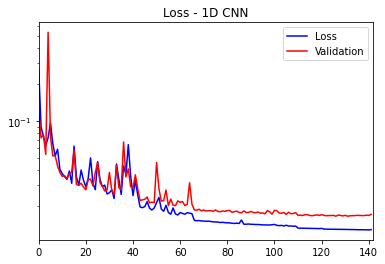

In [9]:
plt.plot(model.history.history['loss'], label="Loss", color='blue')
plt.plot(model.history.history['val_loss'], label="Validation", color='red')
plt.legend()
plt.xlim(0,142)
#plt.ylim(0,10)
plt.yscale("log")
plt.title('Loss - 1D CNN')

### Evaluate on the test data

In [10]:
testGen = DataGenerator(testing, batch_size=1)
errors = model.evaluate(testGen, verbose=1)

334/334 [==============================] - 21s 63ms/step - loss: 0.0173


### Write test file names to an output file

In [11]:
outFile = '/efs/tnarock/regression_noise_y0_revised.txt'

f = open(outFile, "w")
for t in testing:
    line = t.strip() + '\n'
    f.write(line)
f.close()